<a href="https://colab.research.google.com/github/alex160798/final_project/blob/main/Other_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка и импорт библиотек

In [1]:
!pip install pandas_profiling -q
!pip install catboost
!pip install pytorch-tabnet

     |████████████████████████████████| 76.1 MB 1.1 MB/s 


In [2]:
import random
import numpy as np
import pandas as pd
import sys
import string
import pdb
import ast
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
print('Python      :', sys.version.split('\n')[0])
print('Numpy       :', np.__version__)
print('PyTorch     :', torch.__version__)

Python      : 3.7.12 (default, Jan 15 2022, 18:48:18) 
Numpy       : 1.21.5
PyTorch     : 1.10.0+cu111


In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
pip freeze > requirements.txt

## Загрузка данных

In [17]:
df = pd.read_csv('./appointments.csv')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [19]:
df.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
44955,2.568824e+12,5631618,F,2016-04-28T07:16:43Z,2016-05-06T00:00:00Z,71,SÃO JOSÉ,0,1,1,0,0,1,No
33236,5.825879e+14,5594740,F,2016-04-18T11:11:44Z,2016-05-18T00:00:00Z,9,JOANA D´ARC,0,0,0,0,0,0,No
93926,1.692357e+12,5746196,F,2016-05-30T13:35:41Z,2016-06-07T00:00:00Z,1,JARDIM DA PENHA,0,0,0,0,0,0,No
43668,5.183437e+12,5636903,F,2016-04-28T16:32:13Z,2016-05-05T00:00:00Z,10,MARUÍPE,0,0,0,0,0,0,No
44614,6.778285e+12,5729378,F,2016-05-24T07:27:55Z,2016-05-31T00:00:00Z,60,REPÚBLICA,0,1,0,0,0,1,No


In [20]:
#ProfileReport(df)

## Обработка признаков

In [21]:
new_columns = []
for column in df.columns:
    new_columns.append(column.lower())

new_columns[11] = 'handicap'
new_columns[-1] = 'no_show'

df.columns = new_columns

### PatientId

Идентификационный номер пациента. Не полностью уникальные значения, то есть определенные пациенты записывались на прием/консультацию несколько раз, но все же слишком высококая cardinality. Использовать признак не будем.

In [22]:
df.drop('patientid', axis=1, inplace=True)

### AppointmentID

Идентификационный номер записи. Полностью уникальные значения

In [23]:
df.drop('appointmentid', axis=1, inplace=True)

### Gender

Пол пациента. Преимущественно женщины (65%). Считается, что они вообще чаще обращаются за помощью, чем мужчины.

In [24]:
gender_map = {'M' : 0, 'F' : 1}
df.gender = df.gender.map(gender_map)

In [25]:
df.gender.value_counts(dropna=False)

1    71840
0    38687
Name: gender, dtype: int64

### ScheduledDay

Время, на которое назначен прием/консультация. Много уникальных значений, но можно извлечь день/месяц/день недели. Можно также попробовать извлечь часы и минуты, а затем оценить, насколько они важны.

Формат даты: %Y-%m-%dT%H:%M:%SZ

In [26]:
%time
df.scheduledday = df.scheduledday.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df['scheduled_month'] = df.scheduledday.apply(lambda x: x.month)
df['scheduled_day'] = df.scheduledday.apply(lambda x: x.day)
df['scheduled_weekday'] = df.scheduledday.apply(lambda x: x.weekday())

df['scheduled_hour'] = df.scheduledday.apply(lambda x: x.hour)
df['scheduled_minute'] = df.scheduledday.apply(lambda x: x.minute)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


### AppointmentDay

Время, когда пациент записался на прием. Здеесь точность до дня, часы, минуты  секунды указаны 00:00:00

In [27]:
df['appointmentday'] = df.appointmentday.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df['app_month'] = df.appointmentday.apply(lambda x: x.month)
df['app_day'] = df.appointmentday.apply(lambda x: x.day)
df['app_weekday'] = df.appointmentday.apply(lambda x: x.weekday())

### Age

Возраст пациента. Присутствуют странные значения, как -1, или 115 (скорее всего должно быть 15), но их не так много.

### Neighbourhood

Район, в котором будет происходить прием, категориальный признак.

### Scholarship

Получает ли пациент помощь от государства по програмее Bolsa Família, да/нет. Подавляющее большинство (90%) такой помощи не получают. В обработке не нуждается

### Hipertension

Страдает ли пациент повышенным давлением (гипертензией). 80% - нет.

### Diabetes

Болеет ли пациент сахарным диабетом. 92% - нет.

### Alcoholism

Страдает ли пациент от алкоголизма. 97% - нет

### Handcap

Есть ли у пациента инвалидность, и если есть, то какой степени. Учитывая огромный дисбаланс, заменим все значения больше 1 на 1.

In [28]:
df.handicap.value_counts(normalize=True)

0    0.979724
1    0.018475
2    0.001656
3    0.000118
4    0.000027
Name: handicap, dtype: float64

In [29]:
def hand_clear(handicap):
    if handicap > 1:
        handicap = 1
    else:
        handicap = handicap
        
    return handicap

In [30]:
df.handicap = df.handicap.apply(hand_clear)

In [31]:
df.handicap.value_counts(normalize=True)

0    0.979724
1    0.020276
Name: handicap, dtype: float64

Даже так только 2% являются инвалидами.

### SMS_received

Получили ли SMS-напоминание о записи. Обработка не требуется.

### No-show

Явился ли пациент на прием. Целевая переменная.

In [32]:
show_map = {'No' : 0, 'Yes' : 1}
df.no_show = df.no_show.map(show_map)

In [33]:
df.no_show.value_counts()

0    88208
1    22319
Name: no_show, dtype: int64

# Feature Engineering

### days_between

Количество дней между записью и приемом.

In [34]:
def days(data):
  delta = data.appointmentday - data.scheduledday
  return delta.days

In [35]:
df['days_between'] = df.apply(days, axis=1)

### vulnerable_group

Пациент принадлежит к одной из уязвимых групп

In [36]:
def vul_group(data):
  if data.alcoholism == 1 or data.diabetes == 1 or data.handicap == 1 or data.scholarship ==1:
    return 1
  else:
    return 0

In [37]:
df['vulnerable_group'] = df.apply(vul_group, axis=1)

### Проверка очистки

In [38]:
df.drop('appointmentday', axis=1, inplace=True)
df.drop('scheduledday', axis=1, inplace=True)

In [39]:
#ProfileReport(df)

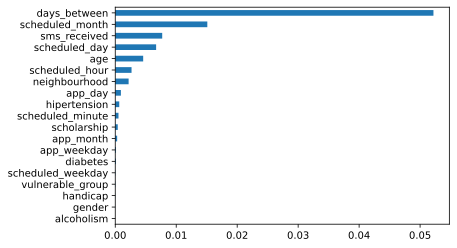

In [40]:
# Преобразуем категориальные признаки в тип данных cat и оценим их важность
# cat_cols = [
#     'gender', 'neighbourhood', 'scholarship', 'hipertension',
#     'diabetes', 'alcoholism', 'handicap', 'sms_received', 
#     'scheduled_month', 'scheduled_day', 'scheduled_weekday',
#     'scheduled_hour', 'scheduled_minute', 'app_month', 
#     'app_day', 'app_weekday'
# ]
# создадим для этого отдельный датафрейм
cat_df = df.copy().drop('no_show', axis=1)

for column in cat_df.columns:
    cat_df[column] = cat_df[column].astype('category').cat.codes

imp_cat = pd.Series(mutual_info_classif(cat_df, df.no_show,
                                     discrete_features =True), index = cat_df.columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Пол, наличие алкоголизма или инвалдности, судя по диаграмме, почти не влияют на результат (в случае алкоголизма и инвалидности несбалансированность в данных огромна, так что это неудивительно).

# Обобщение предобработки (temp)

In [41]:
# def hand_clear(handicap):
#     if handicap > 1:
#         handicap = 1
#     else:
#         handicap = handicap
#     return handicap

# def days(data):
#   delta = data.appointmentday - data.scheduledday
#   return delta.days

# def vul_group(data):
#   if data.alcoholism == 1 or data.diabetes == 1 or data.handicap == 1 or data.scholarship ==1:
#     return 1
#   else:
#     return 0

In [42]:
# df = pd.read_csv('appointments.csv')

# new_columns = []
# for column in df.columns:
#     new_columns.append(column.lower())

# new_columns[11] = 'handicap'
# new_columns[-1] = 'no_show'
# df.columns = new_columns

# gender_map = {'M' : 0, 'F' : 1}
# df.gender = df.gender.map(gender_map)

# df.scheduledday = df.scheduledday.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
# df['scheduled_month'] = df.scheduledday.apply(lambda x: x.month)
# df['scheduled_day'] = df.scheduledday.apply(lambda x: x.day)
# df['scheduled_weekday'] = df.scheduledday.apply(lambda x: x.weekday())
# df['scheduled_hour'] = df.scheduledday.apply(lambda x: x.hour)
# df['scheduled_minute'] = df.scheduledday.apply(lambda x: x.minute)

# df['appointmentday'] = df.appointmentday.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
# df['app_month'] = df.appointmentday.apply(lambda x: x.month)
# df['app_day'] = df.appointmentday.apply(lambda x: x.day)
# df['app_weekday'] = df.appointmentday.apply(lambda x: x.weekday())

# df.handicap = df.handicap.apply(hand_clear)

# show_map = {'No' : 0, 'Yes' : 1}
# df.no_show = df.no_show.map(show_map)

# df['vulnerable_group'] = df.apply(vul_group, axis=1)
# df['days_between'] = df.apply(days, axis=1)

In [43]:
# # Удаление ненужных признаков
# df.drop(['patientid', 'appointmentid', 'appointmentday', 
#          #'neighbourhood',
#          'scheduledday'], axis=1, inplace=True)

## Разделение

In [44]:
X = cat_df
y = df.no_show

In [45]:
# 0.25 x 0.8 = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# Обучение

### Наивная модель

#### Старый baseline

In [46]:
tmp_train = X_train.copy()
tmp_train['no_show'] = y_train

In [47]:
predict = X_test['sms_received'].map(tmp_train.groupby('sms_received')['no_show'].median())
predict.value_counts()

0.0    22106
Name: sms_received, dtype: int64

In [48]:
tmp_train.groupby('sms_received')['no_show'].median()

sms_received
0    0.0
1    0.0
Name: no_show, dtype: float64

In [49]:
#оцениваем точность
print(f"Точность наивной модели по метрике Accuracy: {accuracy_score(y_test, predict)}")
print(f"Точность наивной модели по метрике F1: {f1_score(y_test, predict)}")

Точность наивной модели по метрике Accuracy: 0.7980638740613408
Точность наивной модели по метрике F1: 0.0


Наивная модель всегда использует значение 0, и при этом добивается высокой Accuracy, а метрика F1 равна нулю (поскольку модель ни разу не угадала значение 1). Необходимо решить проблему несбалансированности классов.

#### Новый baseline

In [50]:
y_train.value_counts(normalize=True)

0    0.79807
1    0.20193
Name: no_show, dtype: float64

In [51]:
def myRand(a, p_a, b, p_b):
   return a if random.uniform(0,100) < p_a else b

i = 0
pred = []
while i < len(y_val):
  pred.append(myRand(0, 80, 1, 20))
  i+=1

pred = np.array(pred)

In [52]:
pred.shape

(22106,)

In [53]:
acc = accuracy_score(y_val, pred)
pr = precision_score(y_val, pred)
re = recall_score(y_val, pred)
f1 = f1_score(y_val, pred)

print(f'X_val \nAccuracy: {acc}\nPrecision: {pr} \nRecall: {re} \nF1: {f1}')

X_val 
Accuracy: 0.6787749932145118
Precision: 0.20350798290982686 
Recall: 0.20273297491039427 
F1: 0.20311973964762653


### Логистическая регрессия

In [54]:
model = LogisticRegression( 
    solver='liblinear', 
    class_weight='balanced',
    random_state = RANDOM_SEED
)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [55]:
acc = accuracy_score(y_val, model.predict(X_val))
pr = precision_score(y_val, model.predict(X_val))
re = recall_score(y_val, model.predict(X_val))
f1 = f1_score(y_val, model.predict(X_val))

print(f'X_val \nAccuracy: {acc}\nPrecision: {pr} \nRecall: {re} \nF1: {f1}')

X_val 
Accuracy: 0.6603637021623089
Precision: 0.3146614710180224 
Recall: 0.578853046594982 
F1: 0.40769958977595455


In [56]:
acc = accuracy_score(y_test, model.predict(X_test))
pr = precision_score(y_test, model.predict(X_test))
re = recall_score(y_test, model.predict(X_test))
f1 = f1_score(y_test, model.predict(X_test))

print(f'X_test \nAccuracy: {acc}\nPrecision: {pr} \nRecall: {re} \nF1: {f1}')

X_test 
Accuracy: 0.6656111462951235
Precision: 0.31952662721893493 
Recall: 0.5806451612903226 
F1: 0.41221374045801534


### Catboost Classifier

In [57]:
# Catboost работает с категориальными признаками без доп. обработки
X = df.drop('no_show', axis=1)
y = df.no_show

In [58]:
# 0.25 x 0.8 = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

In [59]:
len(X_train.columns)

19

In [62]:
# cat_features_ids = list(range(0, 17))
cat_features_ids = list(range(0, 19))

In [63]:
model = CatBoostClassifier(
    eval_metric='Recall',
    custom_metric='F1',
    auto_class_weights='Balanced'
)

model.fit(X_train, y_train,
          cat_features=cat_features_ids,
         eval_set=(X_val, y_val),
         verbose_eval=200,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.089299
0:	learn: 0.9218878	test: 0.9171147	best: 0.9171147 (0)	total: 466ms	remaining: 7m 45s
200:	learn: 0.8491524	test: 0.7972670	best: 0.9171147 (0)	total: 45.5s	remaining: 3m
400:	learn: 0.8543051	test: 0.7858423	best: 0.9171147 (0)	total: 1m 28s	remaining: 2m 12s
600:	learn: 0.8613994	test: 0.7710573	best: 0.9171147 (0)	total: 2m 11s	remaining: 1m 27s
800:	learn: 0.8667015	test: 0.7587366	best: 0.9171147 (0)	total: 2m 54s	remaining: 43.4s
999:	learn: 0.8757374	test: 0.7491039	best: 0.9171147 (0)	total: 3m 38s	remaining: 0us

bestTest = 0.9171146953
bestIteration = 0

Shrink model to first 1 iterations.


In [64]:
acc = accuracy_score(y_val, model.predict(X_val))
pr = precision_score(y_val, model.predict(X_val))
re = recall_score(y_val, model.predict(X_val))
f1 = f1_score(y_val, model.predict(X_val))

print(f'X_val \nAccuracy: {acc}\nPrecision: {pr} \nRecall: {re} \nF1: {f1}')

X_val 
Accuracy: 0.5131638469193884
Precision: 0.28261769984812923 
Recall: 0.9171146953405018 
F1: 0.43208443271767805


In [65]:
acc = accuracy_score(y_test, model.predict(X_test))
pr = precision_score(y_test, model.predict(X_test))
re = recall_score(y_test, model.predict(X_test))
f1 = f1_score(y_test, model.predict(X_test))

print(f'X_test \nAccuracy: {acc}\nPrecision: {pr} \nRecall: {re} \nF1: {f1}')

X_test 
Accuracy: 0.5213516692300733
Precision: 0.28595423052697877 
Recall: 0.9153225806451613 
F1: 0.43577027675571905


### Кросс-валидация

In [68]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostClassifier(
        eval_metric='Recall',
        custom_metric='F1',
        auto_class_weights='Balanced'
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features_ids,
        eval_set=(X_test, y_test),
        verbose_eval=200,
        use_best_model=True,
        plot=True
         )
    return(model)

In [69]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=y_val.index) # куда пишем предикты по каждой модели
accuracy_ls = []
precision_ls = []
recall_ls = []
f1_ls = []
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=5,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test)
    # score model on test
    test_predict = model.predict(X_test)

    
    accuracy_ls.append(accuracy_score(y_test, test_predict))
    precision_ls.append(precision_score(y_test, test_predict))
    recall_ls.append(recall_score(y_test, test_predict))
    f1_ls.append(f1_score(y_test, test_predict))

    print(f"{idx+1} Fold Test F1: {f1_score(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_val)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Accuracy: {np.mean(accuracy_ls):0.3f}')
print(f'Mean Precision: {np.mean(precision_ls):0.3f}')
print(f'Mean Recall: {np.mean(recall_ls):0.3f}')
print(f'Mean F1: {np.mean(f1_ls):0.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095876
0:	learn: 0.9180062	test: 0.9254032	best: 0.9254032 (0)	total: 111ms	remaining: 1m 51s
200:	learn: 0.8398208	test: 0.8125000	best: 0.9254032 (0)	total: 50.4s	remaining: 3m 20s
400:	learn: 0.8431812	test: 0.7963710	best: 0.9254032 (0)	total: 1m 42s	remaining: 2m 33s
600:	learn: 0.8510781	test: 0.7880824	best: 0.9254032 (0)	total: 2m 36s	remaining: 1m 43s
800:	learn: 0.8583030	test: 0.7764337	best: 0.9254032 (0)	total: 3m 34s	remaining: 53.2s
999:	learn: 0.8642957	test: 0.7724014	best: 0.9254032 (0)	total: 4m 31s	remaining: 0us

bestTest = 0.9254032258
bestIteration = 0

Shrink model to first 1 iterations.


 20%|██        | 1/5 [04:33<18:12, 273.20s/it]

1 Fold Test F1: 0.437


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095876
0:	learn: 0.9195743	test: 0.9177867	best: 0.9177867 (0)	total: 104ms	remaining: 1m 43s
200:	learn: 0.8401008	test: 0.8053315	best: 0.9177867 (0)	total: 49.1s	remaining: 3m 15s
400:	learn: 0.8478857	test: 0.8001792	best: 0.9177867 (0)	total: 1m 39s	remaining: 2m 29s
600:	learn: 0.8527583	test: 0.7896505	best: 0.9177867 (0)	total: 2m 32s	remaining: 1m 41s
800:	learn: 0.8606553	test: 0.7844982	best: 0.9177867 (0)	total: 3m 25s	remaining: 51.1s
999:	learn: 0.8661999	test: 0.7739695	best: 0.9177867 (0)	total: 4m 21s	remaining: 0us

bestTest = 0.9177867384
bestIteration = 0

Shrink model to first 1 iterations.


 40%|████      | 2/5 [08:56<13:21, 267.25s/it]

2 Fold Test F1: 0.434


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095876
0:	learn: 0.9196909	test: 0.9164239	best: 0.9164239 (0)	total: 172ms	remaining: 2m 51s
200:	learn: 0.8414539	test: 0.8097692	best: 0.9164239 (0)	total: 44.8s	remaining: 2m 58s
400:	learn: 0.8467182	test: 0.7873628	best: 0.9164239 (0)	total: 1m 34s	remaining: 2m 21s
600:	learn: 0.8536626	test: 0.7775039	best: 0.9164239 (0)	total: 2m 25s	remaining: 1m 36s
800:	learn: 0.8613351	test: 0.7714542	best: 0.9164239 (0)	total: 3m 20s	remaining: 49.8s
999:	learn: 0.8669355	test: 0.7627157	best: 0.9164239 (0)	total: 4m 15s	remaining: 0us

bestTest = 0.9164239301
bestIteration = 0

Shrink model to first 1 iterations.


 60%|██████    | 3/5 [13:13<08:45, 262.55s/it]

3 Fold Test F1: 0.434


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095876
0:	learn: 0.9148138	test: 0.9218190	best: 0.9218190 (0)	total: 176ms	remaining: 2m 56s
200:	learn: 0.8415010	test: 0.8131720	best: 0.9218190 (0)	total: 44.4s	remaining: 2m 56s
400:	learn: 0.8490059	test: 0.7965950	best: 0.9218190 (0)	total: 1m 34s	remaining: 2m 21s
600:	learn: 0.8533744	test: 0.7860663	best: 0.9218190 (0)	total: 2m 26s	remaining: 1m 37s
800:	learn: 0.8607113	test: 0.7766577	best: 0.9218190 (0)	total: 3m 20s	remaining: 49.8s
999:	learn: 0.8672081	test: 0.7692652	best: 0.9218190 (0)	total: 4m 20s	remaining: 0us

bestTest = 0.9218189964
bestIteration = 0

Shrink model to first 1 iterations.


 80%|████████  | 4/5 [17:35<04:22, 262.40s/it]

4 Fold Test F1: 0.436


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095876
0:	learn: 0.9185662	test: 0.9164427	best: 0.9164427 (0)	total: 169ms	remaining: 2m 48s
200:	learn: 0.8406049	test: 0.8030914	best: 0.9168907 (1)	total: 43.7s	remaining: 2m 53s
400:	learn: 0.8440213	test: 0.7912186	best: 0.9168907 (1)	total: 1m 33s	remaining: 2m 19s
600:	learn: 0.8487819	test: 0.7773297	best: 0.9168907 (1)	total: 2m 25s	remaining: 1m 36s
800:	learn: 0.8558387	test: 0.7683692	best: 0.9168907 (1)	total: 3m 19s	remaining: 49.5s
999:	learn: 0.8616074	test: 0.7571685	best: 0.9168907 (1)	total: 4m 13s	remaining: 0us

bestTest = 0.916890681
bestIteration = 1

Shrink model to first 2 iterations.


100%|██████████| 5/5 [21:50<00:00, 262.10s/it]

5 Fold Test F1: 0.436
Mean Accuracy: 0.518
Mean Precision: 0.285
Mean Recall: 0.920
Mean F1: 0.435


In [70]:
submissions.to_csv("k_fold.csv")

### TabNet

In [ ]:
tabnet_weights = {0: 1, 1: 3.95}

In [ ]:
# отдельно сделаем предобработку для tabnet
nunique = df.nunique()
types = df.dtypes

categorical_columns = []
categorical_dims =  {}
for col in df.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        continue

In [ ]:
# unused_feat = ['alcoholism', 'handicap', 'scheduled_minute']
unused_feat = []
target = 'no_show'

In [ ]:
features = [ col for col in df.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":10, "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax",
                 "device_name":"cuda"
                }

In [ ]:
X = df[features]
y = df.no_show

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

In [ ]:
X_train

In [ ]:
model = TabNetClassifier(**tabnet_params)

model.fit(
  X_train.values, y_train.values,
  eval_set=[(X_val.values, y_val.values)],
  weights=tabnet_weights,
  patience=50,
  max_epochs=300
)
preds = model.predict(X_test.values)

In [ ]:
acc = accuracy_score(y_test, preds)
pr = precision_score(y_test, preds)
re = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f'X_test \nAccuracy: {acc}\nPrecision: {pr} \nRecall: {re} \nF1: {f1}')